In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [3]:


def haar_1D(input: np.array) -> np.array:
    N = len(input)
    if N % 2 != 0:
        input = input[:-1]
        N -= 1
        
    result = np.zeros(N, dtype=np.float32)
    for i in range(0, N, 2):
        result[i // 2] = (input[i] + input[i + 1]) / 2
        result[N // 2 + i // 2] = (input[i] - input[i + 1]) / 2
    return result

def haar_2d(input: np.array) -> np.array:
    row_transformed = np.apply_along_axis(func1d=haar_1D, axis=1, arr=input)
    final = np.apply_along_axis(func1d=haar_1D, axis=0, arr=row_transformed)
    return final


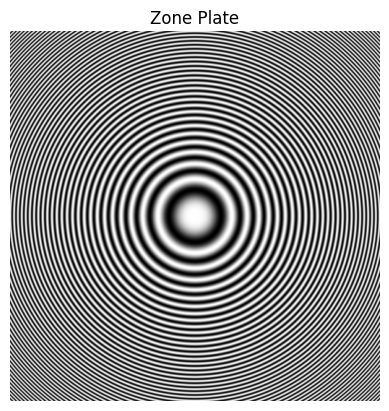

In [4]:
#*******************Part A******************
def generate_zone_plate(size):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)
    radius = np.sqrt(X**2 + Y**2)
    zone_plate = 0.5 * (1 + np.cos(50 * np.pi * radius**2))
    return (zone_plate * 255).astype(np.uint8)

# Generate and display the zone plate
size = 512
zone_plate_image = generate_zone_plate(size)
plt.imshow(zone_plate_image, cmap='gray')
plt.title("Zone Plate")
plt.axis('off')
plt.savefig("output_images/Q2/zone_plate.png")
plt.show()



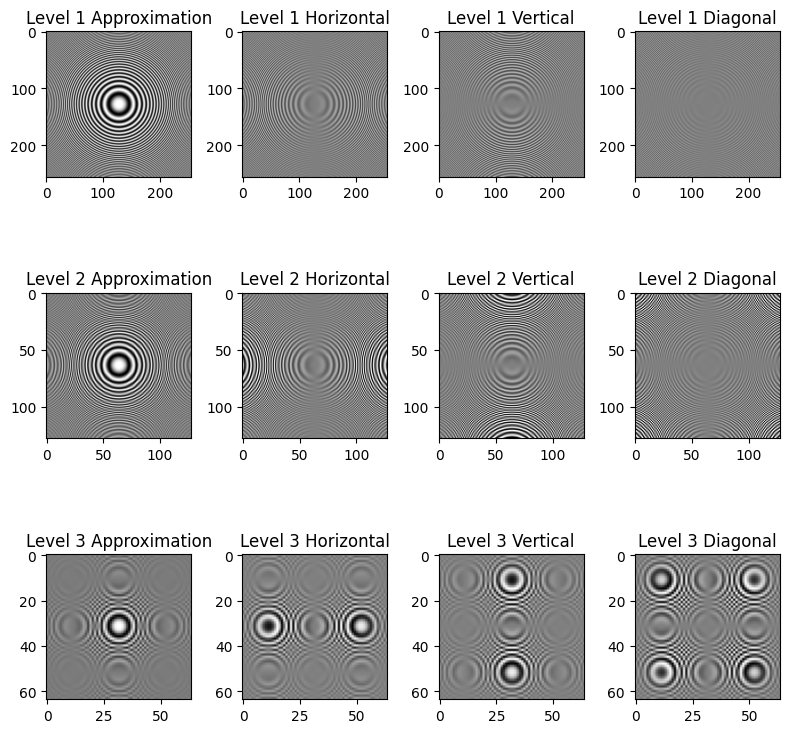

In [5]:

# DWT function with multiple levels
def dwt2D_custom(image, levels=1):
    coeffs_list = []
    current_coeffs = image.astype(np.float32)
    for _ in range(levels):
        transformed = haar_2d(current_coeffs)
        N, M = transformed.shape
        LL = transformed[:N//2, :M//2]
        LH = transformed[:N//2, M//2:]
        HL = transformed[N//2:, :M//2]
        HH = transformed[N//2:, M//2:]
        coeffs_list.append((LL, LH, HL, HH))
        current_coeffs = LL  
    return coeffs_list
levels = 3
coeffs_list = dwt2D_custom(zone_plate_image, levels)

def plot_coefficients(coeffs_list, levels):
    plt.figure(figsize=(8, 8))
    for i in range(levels):
        LL, LH, HL, HH = coeffs_list[i]
        
        plt.subplot(levels, 4, 4 * i + 1)
        plt.imshow(LL, cmap='gray')
        plt.title(f'Level {i+1} Approximation')

        plt.subplot(levels, 4, 4 * i + 2)
        plt.imshow(LH, cmap='gray')
        plt.title(f'Level {i+1} Horizontal')

        plt.subplot(levels, 4, 4 * i + 3)
        plt.imshow(HL, cmap='gray')
        plt.title(f'Level {i+1} Vertical')

        plt.subplot(levels, 4, 4 * i + 4)
        plt.imshow(HH, cmap='gray')
        plt.title(f'Level {i+1} Diagonal')
        
    plt.tight_layout()
    plt.savefig("output_images/Q2/zone_plate_with_levels.png")
    plt.show()

# Plot the coefficients to verify detail coefficients
plot_coefficients(coeffs_list, levels)


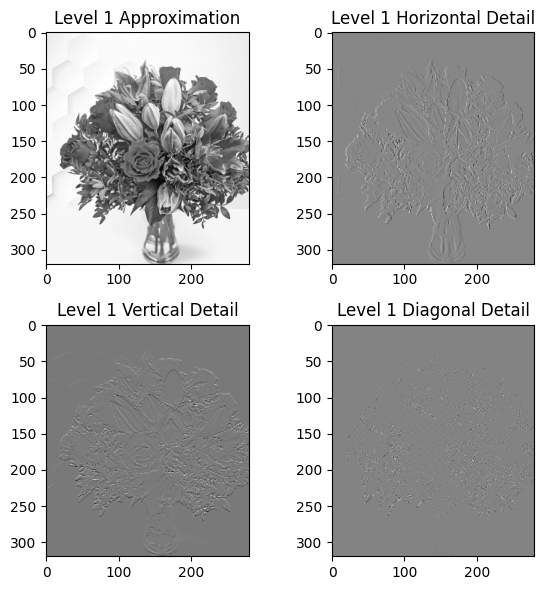

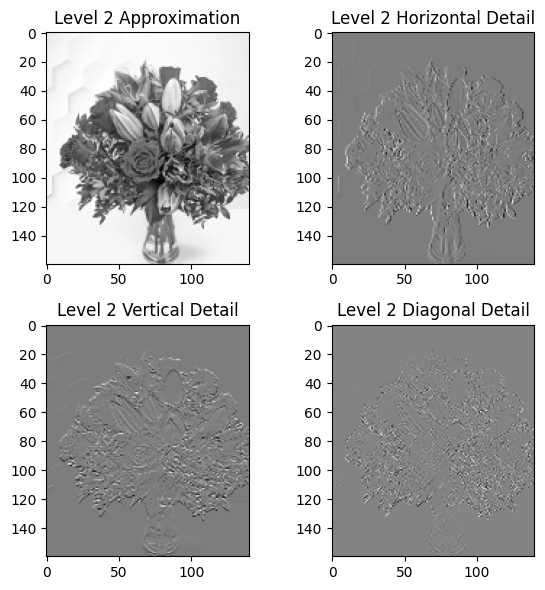

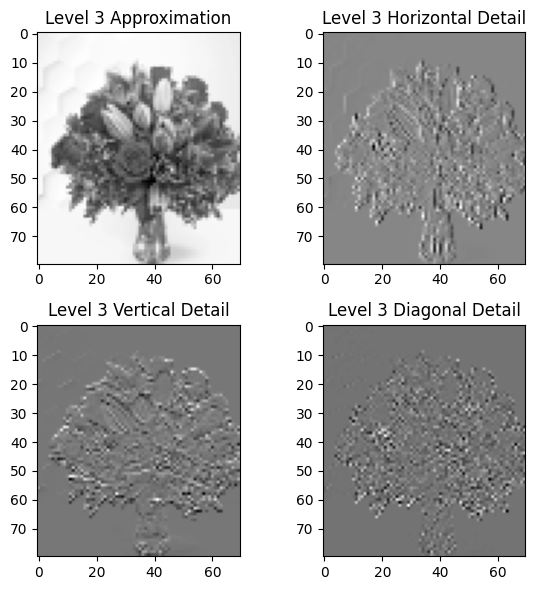

In [6]:

def dwt_multilevel(image, levels):
    coeffs = []
    current_image = image.astype(np.float32)
    for level in range(levels):
        transformed = haar_2d(current_image)
        
        h, w = transformed.shape
        approximation = transformed[:h//2, :w//2]
        horizontal = transformed[:h//2, w//2:]
        vertical = transformed[h//2:, :w//2]
        diagonal = transformed[h//2:, w//2:]
        
        coeffs.append((approximation, horizontal, vertical, diagonal))
        
        current_image = approximation
    return coeffs

flower = cv2.imread("data/flower.png", cv2.IMREAD_GRAYSCALE)
flower1 = flower[:16*40, :16*35]

coefficients = dwt_multilevel(flower1, 3)
levels = 5
import pywt as pt

for level, (approx, horiz, vert, diag) in enumerate(coefficients):
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))
    
    axes[0, 0].imshow(approx, cmap='gray')
    axes[0, 0].set_title(f'Level {level+1} Approximation')
    axes[0, 0].axis('on')
    
    axes[0, 1].imshow(horiz, cmap='gray')
    axes[0, 1].set_title(f'Level {level+1} Horizontal Detail')
    axes[0, 1].axis('on')

    axes[1, 0].imshow(vert, cmap='gray')
    axes[1, 0].set_title(f'Level {level+1} Vertical Detail')
    axes[1, 0].axis('on')
    
    axes[1, 1].imshow(diag, cmap='gray')
    axes[1, 1].set_title(f'Level {level+1} Diagonal Detail')
    axes[1, 1].axis('on')
    
    plt.tight_layout()
    
    plt.savefig(f'level_{level+1}_coefficients.png', bbox_inches='tight', dpi=300)
    
    plt.show()



In [7]:
#########
#***************************************************************************
#***********************Part B**************************
flower = cv2.imread("data/flower.png", cv2.IMREAD_GRAYSCALE)
flower1 = flower[:16*40, :16*35].astype(np.float32)
variance = 0.1
noise = np.random.normal(loc=0, scale=np.sqrt(variance), size=flower1.shape)
noisy_image = flower1 + noise

In [8]:
coeffs_original = pt.dwt2(flower1,'haar')  # Change 'haar' to your desired wavelet
coeffs_noisy =pt.dwt2(noisy_image,'haar')

In [9]:
coeff2 = haar_2d(flower1)
coeffnoise = haar_2d(noisy_image)

In [10]:
dwt_diff = (coeffs_noisy[0] - coeffs_original[0], 
            coeffs_noisy[1][0] - coeffs_original[1][0],
            coeffs_noisy[1][1] - coeffs_original[1][1])

In [11]:
flattened_noise = np.concatenate([dwt_diff[0].flatten(), 
                                   dwt_diff[1].flatten(), 
                                   dwt_diff[2].flatten()])


Mean of the noise: 0.0002938985245407868
Variance of the noise: 0.1000374036358957


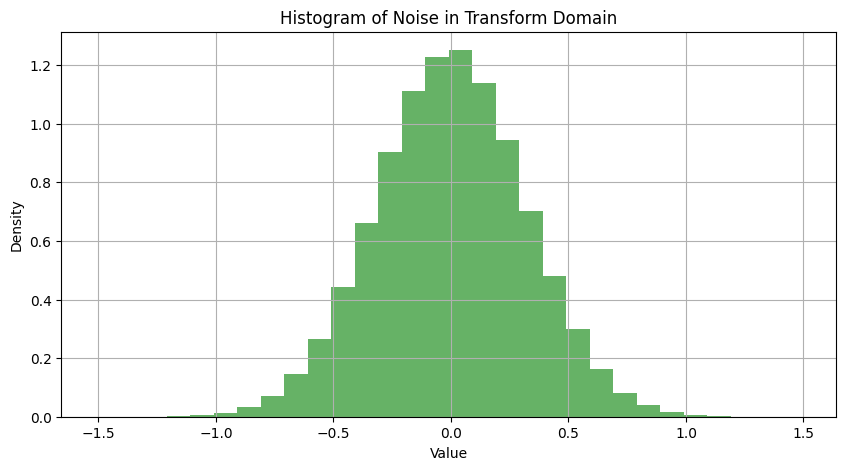

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(flattened_noise, bins=30, density=True, alpha=0.6, color='g')
plt.title('Histogram of Noise in Transform Domain')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid()
mean_noise = np.mean(flattened_noise)
variance_noise = np.var(flattened_noise)

print(f'Mean of the noise: {mean_noise}')
print(f'Variance of the noise: {variance_noise}')
plt.savefig("output_images/Q2/Histogram_noise.png")
plt.show()

In [13]:
flower = cv2.imread("data/flower.png", cv2.IMREAD_GRAYSCALE)
flower1 = flower[:16*40, :16*35].astype(np.float32)
variance = 0.1
noise = np.random.normal(0, np.sqrt(variance), size=flower1.shape)
noisy_image = flower1 + noise

# Step 2: Perform DWT
coeffs_original = haar_2d(flower1)
coeffs_noisy = haar_2d(noisy_image)
# Show results


In [14]:

def inverse_haar_1D(input:np.array)->np.array:
    N = len(input)
    output = np.zeros(N, dtype=np.float32)
    for i in range(N // 2):
        output[2 * i] = input[i] + input[N // 2 + i]
        output[2 * i + 1] = input[i] - input[N // 2 + i]
    return output

# Inverse 2D Haar Transform
def inverse_haar_2D(input):
    row_inversed = np.apply_along_axis(inverse_haar_1D, axis=1, arr=input)
    final = np.apply_along_axis(inverse_haar_1D, axis=0, arr=row_inversed)
    return final


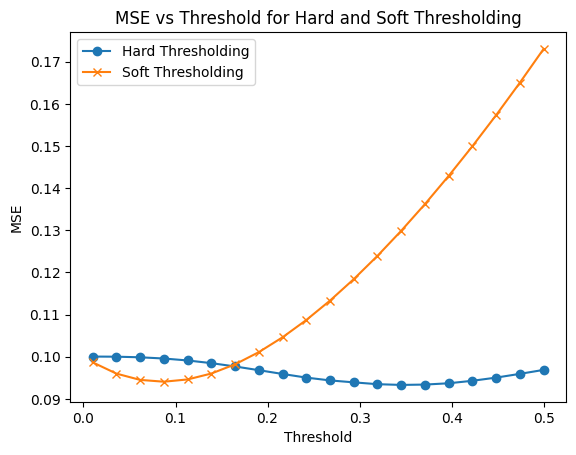

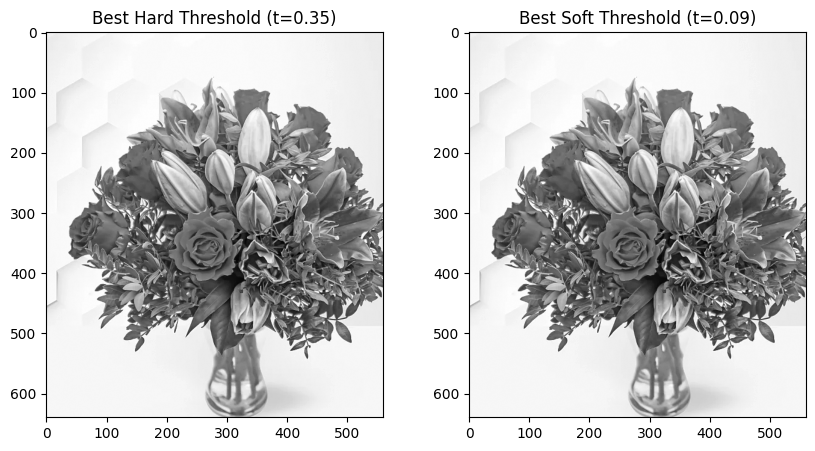

In [15]:

def hard_threshold(d, t):
    return np.where(np.abs(d) <= t, 0, d)

def soft_threshold(d, t):
    return np.where(np.abs(d) <= t, 0, d - np.sign(d) * t)


def denoise(coeffs, t, threshold_type="hard"):
    denoised = coeffs.copy()
    rows, cols = denoised.shape  # Get the number of rows and columns
    
    if threshold_type == "hard":
        denoised[rows // 2:, cols // 2:] = hard_threshold(denoised[rows // 2:, cols // 2:], t)
    elif threshold_type == "soft":
        denoised[rows // 2:, cols // 2:] = soft_threshold(denoised[rows // 2:, cols // 2:], t)
    return denoised

# Define range of thresholds to test
threshold_values = np.linspace(0.01, 0.5, 20)
mse_hard = []
mse_soft = []

# Denoise and calculate MSE for each threshold value
for t in threshold_values:
    # Apply hard thresholding
    denoised_hard = denoise(coeffs_noisy, t, threshold_type="hard")
    reconstructed_hard = inverse_haar_2D(denoised_hard)
    mse_hard.append(np.mean((flower1 - reconstructed_hard) ** 2))
    
    # Apply soft thresholding
    denoised_soft = denoise(coeffs_noisy, t, threshold_type="soft")
    reconstructed_soft = inverse_haar_2D(denoised_soft)
    mse_soft.append(np.mean((flower1 - reconstructed_soft) ** 2))

# Plot MSE vs Threshold for hard and soft thresholding
plt.plot(threshold_values, mse_hard, label="Hard Thresholding", marker='o')
plt.plot(threshold_values, mse_soft, label="Soft Thresholding", marker='x')
plt.xlabel("Threshold")
plt.ylabel("MSE")
plt.title("MSE vs Threshold for Hard and Soft Thresholding")
plt.legend()
plt.savefig("output_images/Q2/MSE  vs threshold.png")
plt.show()

best_threshold_hard = threshold_values[np.argmin(mse_hard)]
best_threshold_soft = threshold_values[np.argmin(mse_soft)]

best_denoised_hard = denoise(coeffs_noisy, best_threshold_hard, threshold_type="hard")
best_reconstructed_hard = inverse_haar_2D(best_denoised_hard)

best_denoised_soft = denoise(coeffs_noisy, best_threshold_soft, threshold_type="soft")
best_reconstructed_soft = inverse_haar_2D(best_denoised_soft)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(best_reconstructed_hard, cmap='gray')
plt.title(f"Best Hard Threshold (t={best_threshold_hard:.2f})")
plt.subplot(1, 2, 2)
plt.imshow(best_reconstructed_soft, cmap='gray')
plt.title(f"Best Soft Threshold (t={best_threshold_soft:.2f})")
plt.savefig("output_images/Q2/denoised_image.png")

plt.show()
